# Principal Component Analysis
## Foundations of Machine Learning
## `! git clone https://github.com/DS3001/PCA`

In [7]:
! git clone https://github.com/DS3001/PCA

fatal: destination path 'PCA' already exists and is not an empty directory.


## Principal Component Analysis
- We've seen that when features/covariates are correlated, it can lead to problems, multi-colinearity and bad control being the main examples
- A common situation is: We have seven or eight measures of essentially the same variable, like income or health status, and "throwing them all in" seems to lead to bad results
- Question 1: How can we disentangle a set of correlated variables?
- Question 2: If we have a highly correlated set of variables that is "large", can we jointly reduce their dimension down to a smaller set of transformed variables that captures the main variation in the original set?
- The traditional solution to these questions is **Principal Component Analysis**, or **PCA**
- This is a more mechanical tool that is typically used "under the hood" in an analysis, as an intermediate step to getting higher quality results

## Examples
- We've seen this come up in our data frequently:
    - In the GSS, there were often a basket of questions that all tried to capture a similar --- but difficult to measure --- concept from different angles, like social/economic attitudes or attributes
    - In clinical settings, we might have a bunch of indicators of health
    - In the pretrial data, we might want to construct a measure of "criminal record", but the variables that we might use for this purpose are all highly correlated
    - In hedonic pricing with houses, larger houses typically have larger garages and more bathrooms and bedrooms and so on, so that
- Before moving on to the PCA algorithm, let's compute some correlation matrices to see this phenomenon in practice

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Heart Attacks
- There are a variety of measurements in the heart attack data that exhibit correlation. How closely are they all related? In particular, how are the measurements correlated?

In [21]:
df_heart = pd.read_csv('/content/PCA/data/heart_failure_clinical_records_dataset.csv')
df_heart.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [22]:
X_heart = df_heart.loc[:,['anaemia', 'creatinine_phosphokinase', 'ejection_fraction', 'serum_creatinine', 'serum_sodium'] ]
X_heart.corr()

,anaemia,creatinine_phosphokinase,ejection_fraction,serum_creatinine,serum_sodium
anaemia,1.000000,-0.190741,0.031557,0.052174,0.041882
creatinine_phosphokinase,-0.190741,1.000000,-0.044080,-0.016408,0.059550
ejection_fraction,0.031557,-0.044080,1.000000,-0.011302,0.175902
serum_creatinine,0.052174,-0.016408,-0.011302,1.000000,-0.189095
serum_sodium,0.041882,0.059550,0.175902,-0.189095,1.000000


## Justice Data
- In analyzing sentences and bonds, we might want to include information about a defendant's prior record, but there are many ways to approach that question

In [23]:
df_vcc = pd.read_csv('/content/PCA/data/pretrial_data.csv')
df_vcc.head()

,Unnamed: 0,case_type,age,sex,race,is_poor,bond,bond_type,prior_F,prior_M,gini,released,sentence_type,sentence,bond_NA,held_wo_bail,sentence_NA
0,0,F,31.0,M,W,NaN,NaN,7,0.0,0.0,0.44,NaN,NaN,NaN,True,False,True
1,1,F,60.0,M,B,NaN,NaN,7,13.0,21.0,0.44,0.0,0.0,60.000000,True,False,False
2,2,M,27.0,M,W,NaN,NaN,7,0.0,0.0,0.44,0.0,1.0,12.000000,True,False,False
3,3,M,27.0,M,B,0.0,NaN,7,0.0,9.0,0.44,0.0,1.0,0.985626,True,False,False
4,4,F,28.0,F,W,0.0,NaN,7,0.0,0.0,0.44,1.0,4.0,0.000000,True,False,True


In [24]:
X_vcc = df_vcc.loc[:,['prior_F', 'prior_M'] ]
X_vcc = X_vcc.dropna()
X_vcc.corr()

,prior_F,prior_M
prior_F,1.000000,0.424863
prior_M,0.424863,1.000000


## Hedonic Pricing
- We want to control for the "size" of the house, but we have a bunch of different metrics of house size that are all highly correlated

In [25]:
df_house = pd.read_csv('/content/PCA/data/pierce_county_house_sales.csv')
df_house.head()

,sale_date,sale_price,house_square_feet,attic_finished_square_feet,basement_square_feet,attached_garage_square_feet,detached_garage_square_feet,fireplaces,hvac_description,exterior,interior,stories,roof_cover,year_built,bedrooms,bathrooms,waterfront_type,view_quality,utility_sewer
0,2020-01-02,380000,2157,0,0,528,0,0,Warm and Cool Air Zone,Frame Siding,Drywall,2,Composition Shingle,1993,3,3,NaN,NaN,SEWER/SEPTIC INSTALLED
1,2020-01-02,383000,2238,0,0,396,0,0,Forced Air,Frame Siding,Drywall,2,Composition Shingle,2017,4,3,NaN,NaN,SEWER/SEPTIC INSTALLED
2,2020-01-01,419900,1452,0,0,0,0,1,Forced Air,Frame Siding,Drywall,1,Built Up Rock,1965,3,2,NaN,NaN,SEWER/SEPTIC INSTALLED
3,2020-01-02,251660,832,0,0,0,0,0,Forced Air,Frame Vinyl,Drywall,1,Composition Shingle,1919,2,1,NaN,NaN,SEWER/SEPTIC INSTALLED
4,2020-01-02,500000,1780,0,384,484,0,1,Forced Air,Frame Siding,Drywall,1,Composition Shingle,1955,3,2,NaN,NaN,SEWER/SEPTIC INSTALLED


In [26]:
X_house = df_house.loc[:, ['house_square_feet', 'attic_finished_square_feet', 'basement_square_feet',
                           'attached_garage_square_feet', 'detached_garage_square_feet', 'bedrooms', 'bathrooms', 'stories'] ]
X_house.dropna()
X_house.corr()

,house_square_feet,attic_finished_square_feet,basement_square_feet,attached_garage_square_feet,detached_garage_square_feet,bedrooms,bathrooms,stories
house_square_feet,1.000000,-0.138098,0.000840,0.565737,-0.055445,0.587945,0.742463,0.555438
attic_finished_square_feet,-0.138098,1.000000,0.074765,-0.160113,0.075351,-0.039005,-0.137345,-0.182160
basement_square_feet,0.000840,0.074765,1.000000,-0.164349,0.066942,0.108674,0.098573,-0.121985
attached_garage_square_feet,0.565737,-0.160113,-0.164349,1.000000,-0.214052,0.306366,0.528836,0.304699
detached_garage_square_feet,-0.055445,0.075351,0.066942,-0.214052,1.000000,-0.067237,-0.077656,-0.081461
bedrooms,0.587945,-0.039005,0.108674,0.306366,-0.067237,1.000000,0.569182,0.420779
bathrooms,0.742463,-0.137345,0.098573,0.528836,-0.077656,0.569182,1.000000,0.558733
stories,0.555438,-0.182160,-0.121985,0.304699,-0.081461,0.420779,0.558733,1.000000


## The General Set-up
- This is arguably an unsupervised learning algorithm, like $K$-means clustering: We're going to take a set of variables and transform them into new variables that provide new or different information that wasn't obvious from the original set
- We have $ X=  \{ x_1, x_2, ..., x_K \} $ vectors, and they are highly correlated; these are typically a subset of the original variables, not the entire dataset
- We'd like to transform $X$ into a new set of vectors, $Z$, which are optimally de-correlated for analysis

## Orthognonal Means Uncorrelated/Independent
- We know that the covariance between our vectors is "a problem": Because the information in each vector isn't independent of the information in the other vectors, algorithms will struggle to make the best use of the information available
    - With the LASSO, when presented with two highly correlated variables, it will typically choose the "better" variable and throw away the unused information in the other variable. That's a waste.
    - With decision trees, when presented with two highly correlated variables, it will make a split on one, ignoring the common variation between the two variables, and perhaps missing out on some valuable discriminatory power. That's a waste.
- How do we "disentangle" these variables to avoid wasting information?
- We go back to the concept of "orthogonal": Two variables $i$ and $j$ are independent or orthogonal if $$ \text{corr}(x_i, x_j) = \dfrac{\text{cov}(x_i - \bar{x}_i, x_j - \bar{x}_j)}{\sigma_i \sigma_j} = 0,$$ where $\bar{x}_i$ is the mean of $x_i$ and $\sigma_i$ is the standard deviation of $x_i$
- What we really want to do is orthogonalize our variables so that we can use the de-correlated versions in our analysis

## The PCA Algorithm [Math: Linear Algebra]
If you were trapped on a desert island and had to do PCA, here are the steps:

0. **Demean the Variables in $X$**: Subtract off the average value of each variable, so all of the variables are centered around 0, so $z_k = x_k - \bar{x}_k$
1. **Compute the Correlation Matrix of $X$**: Compute the $K \times K$ covariance matrix of $Z$,
$$ \text{cov}(Z) = \left[ \begin{array}{cccc} \sigma_1^2 & \text{cov}(z_1,z_2) & \dots & \text{cov}(z_1,z_K) \\ \text{cov}(z_2,z_1) & \sigma_2^2 & \dots &  \\ \vdots & \vdots & \ddots & \vdots \\ \text{cov}(z_K,z_1)  & \text{cov}(z_K,z_2) & \dots & \sigma_K^2 \end{array} \right] $$
2. **Perform a Eigenvalue Decomposition of $\text{cov}(Z)$**: This transforms $\text{cov}(Z) = PDP^{-1}$, where $D$ is a diagonal matrix with elements $(\lambda_1, \lambda_2, ..., \lambda_K)$, called eigenvalues, satisfying $\lambda_1 \ge \lambda_2 \ge ... \ge \lambda_K$. (Because $\text{cov}(Z)$ is a covariance matrix, we know that all of the eigenvalues are real numbers and non-negative)
3. **Transform the Data**: Take the first $L$ eigenvectors of the decomposition of the correlation matrix, $P_{1:K, 1:L}$, multiply this times the original data, and add the means back in, as
$$
X_{PCA} = Z \cdot P_{1:K,1:L} + \bar{x}[1:L]
$$
This gives an $(N \times K) \times (K \times L) = N \times L$ matrix, reducing the dimension of the data from $K$ to $L$.

In [27]:
# Eigenvalue decomposition decorrelates a matrix as much as possible.

In [28]:
## A PCA Decomposition of Housing Variables:

def demean(x):
    xbar = np.mean(x)
    z = x-xbar
    return(z)
Z_house = X_house.apply(demean) # Z is the demeaned X
X_mean = X_house.mean().to_numpy() # Compute variable averages

# Step 1: Compute correlation matrix
C_house = Z_house.cov()

# Step 2: Eigen decomposition and rank by eigenvalues
eigenvalues, eigenvectors = np.linalg.eig(C_house) # Perform eigenvalue decomposition

eig_val = eigenvalues[ np.argsort(-eigenvalues) ]
eig_vect = eigenvectors[ :, np.argsort(-eigenvalues) ]
x_means = X_mean[ np.argsort(-eigenvalues) ]
eig_val = eig_val/np.sum(eig_val)
eig_vect = eig_vect #/np.sum(eig_vect,axis = 1)
print('Sorted Eigenvalues: ', eig_val, '\n')
print('Sorted Eigenvectors: ', eig_vect, '\n')

# Step 3: Compute Feature Matrix
L = 3 # Number of principal components to use
components = eig_vect[:,0:L]
x_means = x_means[:L]

# Step 4: Transform Variables
transformed = Z_house @ components +x_means # Multiple original data times the principal componenet filter, plus the mean

print('Dimensions of final data: ', transformed.shape) # Dimension reduction!


Sorted Eigenvalues:  [6.88906964e-01 2.12304410e-01 5.95085835e-02 2.79028394e-02
 1.13761086e-02 6.27513690e-07 3.07117581e-07 1.60085543e-07] 

Sorted Eigenvectors:  [[ 9.73034349e-01 -4.50364495e-02 -2.20470650e-01 -4.96478661e-02
  -1.01257306e-02 -9.64439879e-04 -4.38123471e-04 -5.06390508e-05]
 [-1.93523087e-02 -1.95685522e-02 -4.28206661e-02  3.22016989e-02
  -9.98184146e-01 -1.14172180e-04  5.18027247e-04  3.62339891e-04]
 [-1.06218974e-02 -9.88074765e-01  1.52901472e-01  6.44498471e-03
   1.32250455e-02 -2.63704095e-04 -6.77617691e-05  2.43695588e-04]
 [ 2.29057686e-01  1.41345991e-01  9.20777281e-01  2.79826095e-01
  -3.76846694e-02 -1.07761254e-04 -4.27750406e-04  3.37015273e-04]
 [-1.57538378e-02 -3.63075586e-02 -2.79909302e-01  9.58203435e-01
   4.39368274e-02  2.83610118e-04 -8.46396938e-06  1.12041924e-04]
 [ 6.67271735e-04 -2.53814008e-04 -1.25023255e-04 -2.92554036e-04
  -3.31366883e-04  9.15586753e-01 -4.01768187e-01 -1.68077870e-02]
 [ 7.95949003e-04 -1.99279819e-04 

## How to Pick the Number of Components
- Since PCA can be understood as a projection/regression, we can define an $R^2$ measure: How much of the variation in the original data is explained by the transformed data?
- This corresponds to summing the eigenvalues, once they're normalized so they sum to 1
- If you merely plot the normalized eigenvalues, you get a scree plot: How much variation does each component explain? Find the elbow, etc.
- If you cumulatively sum the normalized eigenvalues, you get the total $R^2$ of that number of components: How much total variation is explained by this many components?
- The number of components requried depends on the applications

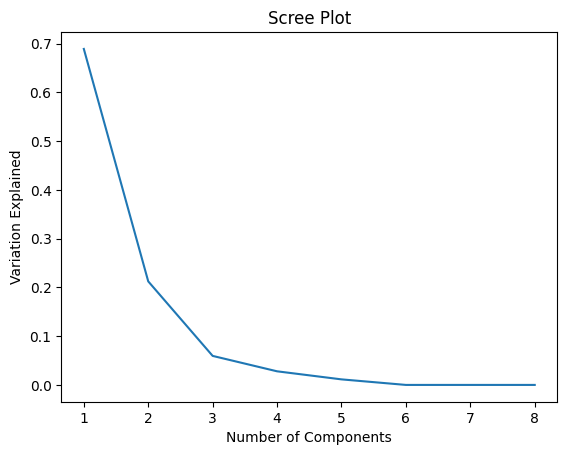

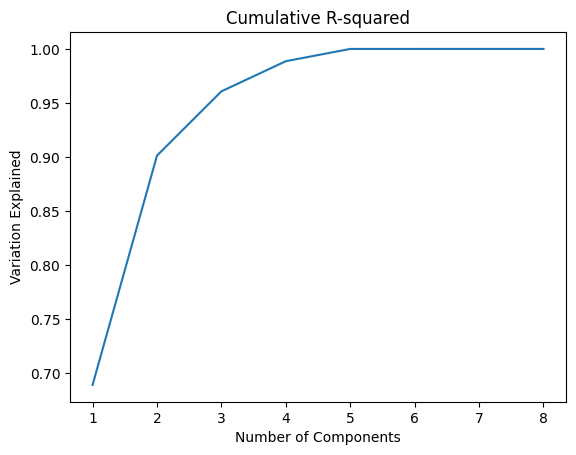

In [29]:
# Scree plot:
x = np.linspace(1, Z_house.shape[1],Z_house.shape[1])
y = eig_val
plt.plot(x,y)
plt.xlabel("Number of Components")
plt.ylabel("Variation Explained")
plt.title('Scree Plot')
plt.show()

# R^2 plot:
x = np.linspace(1, Z_house.shape[1],Z_house.shape[1])
y = np.cumsum(eig_val)
plt.plot(x,y)
plt.xlabel("Number of Components")
plt.ylabel("Variation Explained")
plt.title('Cumulative R-squared')
plt.show()

In [30]:
# This means that the first 2 variables can account
#  for 90% of the relationships within the data.

## Why does PCA Work?
- The core idea of eigenvalue decomposition is to take a symmetric matrix (the covariance matrix) and decompose it into a set of vectors that are independent/orthogonal
- Picking the first $L$ of $K$ components of that decomposition and multiplying it by the data yields a transformation of the original data in a simpler space: We embed the original data in a lower dimensional space
- PCA can be interepted as solving a minimization problem: Pick $L$ vectors that minimize the sum of squared error of the original data to the transformed data, where the transformed data live in a lower dimensional space

## PCA with Sci-Kit
- Of course, sci-kit implements this in a fairly straightforward way:
    1. Import your PCA class: `from sklearn.decomposition import PCA`
    2. Create a PCA class instance: `pca = PCA(n_components = L)`
    3. Fit the PCA transformer: `pca.fit(X)`
    4. Transform the data as desired: `pca.transform(X_new)`
- Sci-Kit does other things besides the steps I listed above. The steps I gave are "vanilla" PCA and Sci-Kit is more of a spicy PCA.

In [31]:
## Housing PCA with sci-kit:
from sklearn.decomposition import PCA # Import PCA class
pca = PCA(n_components = 1) # Create PCA instance
pca = pca.fit(X_house) # Create the decomposition
Z_house = pca.transform(X_house) # Project house data; could use new data or test data

## Application: Indices
- There are a variety of indices published for making comparisons across countries: Human Development Index, V-Dem
- Take your correlated variables on topic $Y$, conduct PCA, extract the first componenet, and call that an "Index of $Y$"
- This is particularly popular in finance, and people try to brand the principal components: "Volatility", "Liquidity", etc.
- I am deeply skeptical of this kind of work. To me, PCA is a computational step to get traction on handling high dimensional data, and not an end in itself. Interpreting the eigenvalues and components can often drift closer to astrology than science.

In [32]:
X_vcc

,prior_F,prior_M
0,0.0,0.0
1,13.0,21.0
2,0.0,0.0
3,0.0,9.0
4,0.0,0.0
...,...,...
22980,1.0,3.0
22981,12.0,2.0
22983,6.0,2.0
22984,1.0,0.0


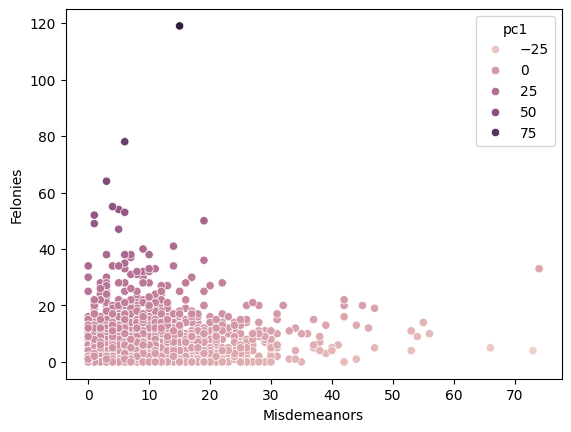

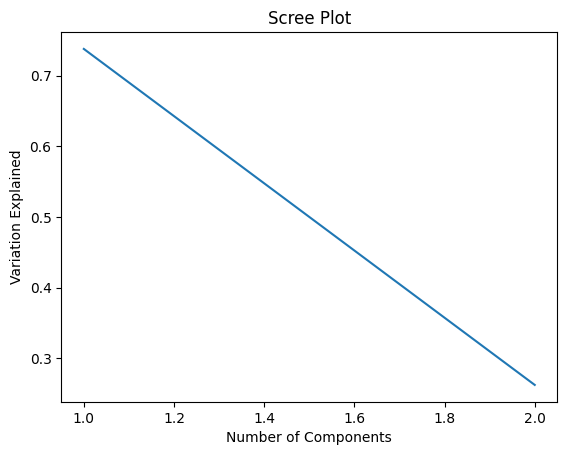

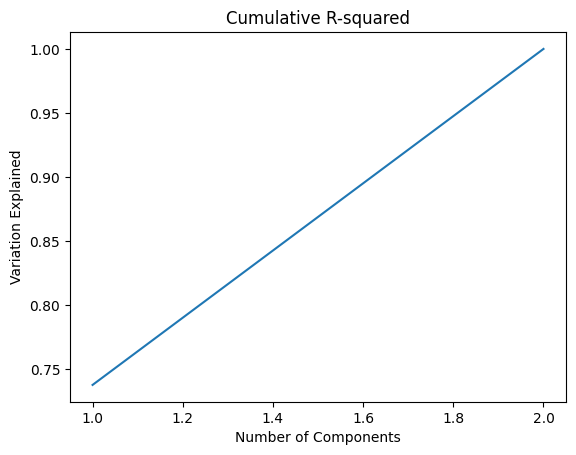

[0.73776573 0.26223427]


In [33]:
# Can we build a single-dimensional "past record index" from the justice data?

from sklearn.decomposition import PCA # Import PCA class
pca = PCA(n_components = 2) # Create PCA instance
pca = pca.fit(X_vcc) # Create the decomposition
Z_vcc = pca.transform(X_vcc) # Project house data; could use new data or test data

gdf = pd.DataFrame({'Misdemeanors':X_vcc['prior_M'],
                    'Felonies':X_vcc['prior_F'],
                    'pc1':Z_vcc[:,1]})
sns.scatterplot(data=gdf,x='Misdemeanors', y='Felonies',hue='pc1')
plt.show()

eig_values = (pca.singular_values_)**2 # Singular values are the square root of eigenvalues
eig_values = eig_values/np.sum(eig_values) # Rescale so the sum of eigenvalues is 1

# Scree plot:
x = np.linspace(1, Z_vcc.shape[1],Z_vcc.shape[1])
y = eig_values
plt.plot(x,y)
plt.xlabel("Number of Components")
plt.ylabel("Variation Explained")
plt.title('Scree Plot')
plt.show()

# R^2 plot:
x = np.linspace(1, Z_vcc.shape[1],Z_vcc.shape[1])
y = np.cumsum(eig_values)
plt.plot(x,y)
plt.xlabel("Number of Components")
plt.ylabel("Variation Explained")
plt.title('Cumulative R-squared')
plt.show()

print(eig_values)

# So the one dimensional index gets 73% of the variation of the two variables together

## Application: Indices
- So, in many situations, you have a variety of correlated measures of the same phenomenon, like "Past Record"
- Here, the first principal component seems to track mostly the felonies; that might be fine
- You can use the first Principal Component to proxy for the basket of variables, rather than try to use them all
- The first principal component explains about 73% of the variation in outcomes, so it's not bad, but in high stakes settings, 73% might not be enough --- I certainly wouldn't want to recommend holding someone without bond on the basis of 73%

## Application: Clustering and Dimension Reduction
- When clustering, we often do PCA on the clustering variables to orthogonalize them and improve performance
- So you first maxmin normalize, then apply PCA, and finally conduct the $K$-means algorithm (or another) on the transformed data
- This also aids visualization: You can plot the first two principal components against the final cluster assignment to visualize your results, even when the data are high-dimensional

In [34]:
import seaborn as sns

## Maxmin normalize:
def maxmin(x): # Max-min scaler function
    x = (x-min(x))/(max(x)-min(x))
    return x
X_mm = X_house.apply(maxmin) # Normalize the data

## Implement PCA:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
pca = pca.fit(X_mm)
Z_house = pca.transform(X_mm)

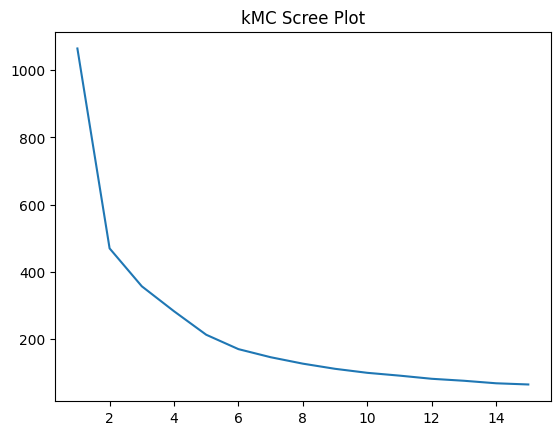

In [35]:
## Implement Clustering:
from sklearn.cluster import KMeans
k_bar = 15
SSE = np.zeros(k_bar)
for k in range(k_bar): # For indices from 0 to k_bar-1
    model = KMeans(n_clusters=k+1, max_iter=300, n_init = 10, random_state=0) # Create a model for k
    model = model.fit(Z_house) # Fit the emodel
    SSE[k] = model.inertia_ # Record the sum of squared error for k in the SSE vector
scree_plot = sns.lineplot(x=np.linspace(1,k_bar,k_bar), y=SSE).set_title('kMC Scree Plot') # Create scree plot

# Five looks good

<Axes: xlabel='pc1', ylabel='pc2'>

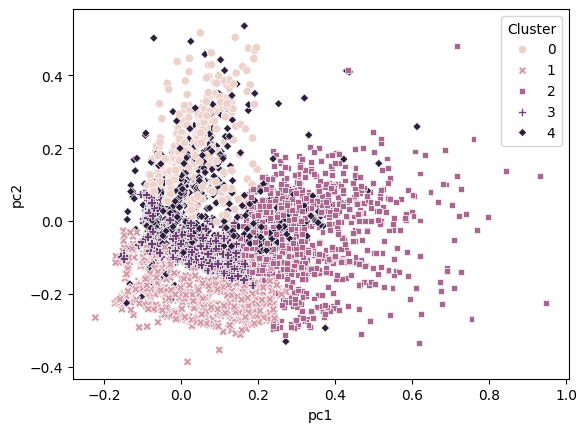

In [36]:
model = KMeans(n_clusters=5, n_init=10, random_state=1)
model = model.fit(Z_house)
cluster_hat = model.predict(Z_house)

gdf = pd.DataFrame({'pc1':Z_house[:,1],
                    'pc2':Z_house[:,2],
                    'Cluster':cluster_hat})
sns.scatterplot(data=gdf,x='pc1', y='pc2',hue='Cluster',style='Cluster')


## Application: Clustering and Dimension Reduction
- So we use PCA to decorrelate the variables, and then use just the first two principal components to make the scatter plot
- This kind of trick works really well in high dimensional situations, where we want to use all the data but our ability to conceptualize what's happening in more than two/three dimensions is very limited
- We are still omitting some of the principal components, which didn't span the original data set --- we are losing something, for sure. You could use the PCA scree plot of $R^2$ to assess the loss.
- What do the principal components mean? What do the clusters mean? No clue! It's just a computational/statistical step, unless we want to dig into the results and psycho-analyze what they mean.

## Application: Regression
- Rather than LASSO or fuss around to do feature selection, why not transform the data with PCA, then chose which $L$ of $K$ transformed variables to include as features/covariates?
- This is very clever: For $K$ features/covariates, there are $2^K$ possible choices of subsets of variables, while with PCA, there are only $K$ ways to choose the first $L$ principal components
- Problem: Explainability/Interpretability suffers, because we can't really make sense of what the transformed variables really mean. They're just a technology to make predictions, and rely on the dimensions we dropped. You can use this for prediction-making, but interpreting indices and including them as covariates is not typically a responsible thing to do.

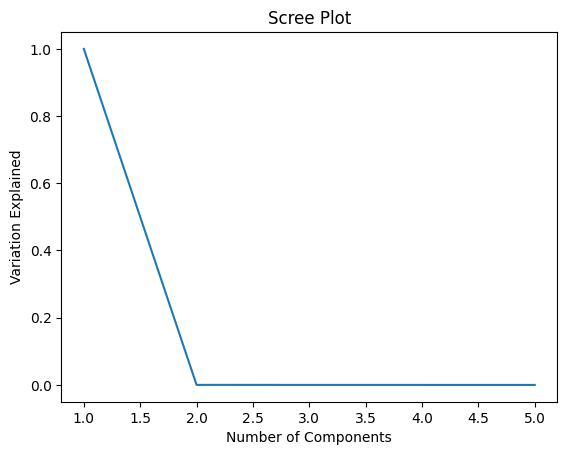

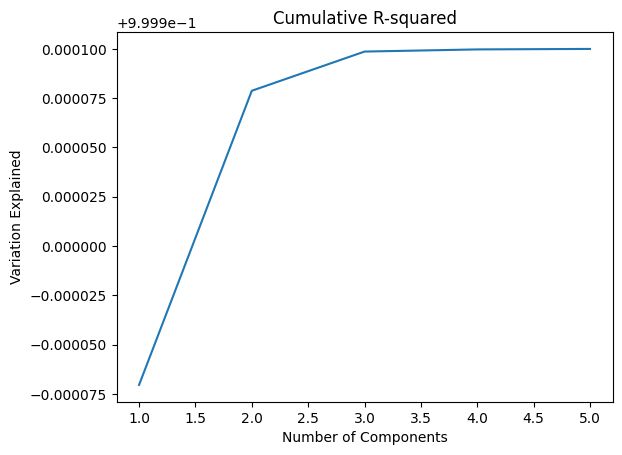

[9.99829550e-01 1.49221028e-04 1.98851691e-05 1.09421090e-06
 2.49850301e-07]


In [37]:
def demean(x):
    xbar = np.mean(x)
    z = x-xbar
    return(z)
Z_heart = X_heart.apply(demean)
X_mean = Z_heart.mean().to_numpy()

## Eigendecompose the VCV matrix of Z_heart:
C_heart = Z_heart.cov() # Compute covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(C_heart) # Perform eigenvalue decomposition
eig_val = eigenvalues[ np.argsort(-eigenvalues) ]
eig_vect = eigenvectors[ :, np.argsort(-eigenvalues) ]
x_means = X_mean[ np.argsort(-eigenvalues) ]
eig_val = eig_val/np.sum(eig_val)
eig_vect = eig_vect

# Scree plot:
x = np.linspace(1, Z_heart.shape[1],Z_heart.shape[1])
y = eig_val
plt.plot(x,y)
plt.xlabel("Number of Components")
plt.ylabel("Variation Explained")
plt.title('Scree Plot')
plt.show()

# R^2 plot:
x = np.linspace(1, Z_heart.shape[1],Z_heart.shape[1])
y = np.cumsum(eig_val)
plt.plot(x,y)
plt.xlabel("Number of Components")
plt.ylabel("Variation Explained")
plt.title('Cumulative R-squared')
plt.show()

print(eig_val)

> So, the take-away here is that the first principal component explains 99% of the variation. This is a pretty outrageous success, as it were. We can use just one variable to represent the entire basket. Let's add the first principal component into the dataframe, and run some regressions.

In [38]:
## Extract first principal component:
L = 1 # Number of principal components to use
components = eig_vect[:,0:L]
x_means = x_means[:L]
transformed = Z_heart @ components +x_means
df_heart['pc1'] = transformed

In [39]:
# Linear regression with first pca
df_heart['age_sq'] = df_heart['age']**2
ctrl = ['age', 'age_sq', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'pc1']

X = df_heart.loc[:,ctrl]
y = df_heart['DEATH_EVENT']
X.head()

,age,age_sq,diabetes,high_blood_pressure,sex,smoking,pc1
0,75.0,5625.0,0,1,1,0,0.168498
1,55.0,3025.0,0,0,1,0,7279.159103
2,65.0,4225.0,0,0,1,1,-435.831681
3,50.0,2500.0,0,0,1,0,-470.829616
4,65.0,4225.0,1,0,0,0,-421.835326


In [40]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X,y)
print(reg.intercept_) # Intercept value
print(reg.coef_) # Regression coefficients
print(reg.score(X, y)) # R squared measure

0.8266251732250689
[-2.75103675e-02  2.97640491e-04  3.33994609e-02  6.49786386e-02
 -2.28214242e-02  7.99019366e-03  3.96923368e-05]
0.08888496008461111


## Application: Image and Sound Processing
- Images are typically very high dimensional data: Imagine a black-and-white image is encoded as $R \times C$ pixel values of grey coded from white to black. For a high resolution photo, that will be extremely high dimensional (and for color we would have to track four such matrices, corresponding to cyan/magenta/yellow/black)
- PCA provides a way of "strategically throwing away" data to compress images and sound by filtering by the first $K$ components

## Application: Natural Language Processing
- PCA is used extensively in the natural language processing literature as something called word2vec
- How do you word2vec?
    0. **Tokenize** your text by breaking it into words or n-grams
    1. One-hot encode your sentences. A row is a sentence and a column is a token, and a value answers the question, "Does this sentence include this token?"
    2. Take the transpose. Now, a row is a token and a column is a sentence, and a value answers the question, "Does this token appear in this sentence?"
    3. Conduct PCA to get a **vector embedding** of words into a feature space
- This is the core tool of modern NLP to convert text into a format that we can analyze; notice, it's the same thing as image processing

## Application: Recommender Systems and Matrix Completion
- Think about the kind of data that Netflix has: Millions of users, and their ratings for movies
- Imagine each row is a user and each column is a movie. Then a value is a rating for a movie
- Netflix's problem is missing values: They don't know how you'll respond to a movie you've never seen
- Netflix (and other companies) use PCA-type methods to infer how people decide to rate movies, and impute values. Then they make recommendations on the basis of the imputation.

## Conclusion
- PCA is a very valuable tool to have available for dimensionality reduction of complex data, and appears everywhere "under the hood" to handle problems when you have "too many variables"
- Whenever you're in a situation where you have baskets of variables that are all similar, you can de-correlate them and scale the complexity of the resulting set up and down to taste
- This is primarily a computational tool that conducts an intermediate step to process data, and interpreting the results is kind of fool-hardy unless you really know what you're doing. Personally, I am very skeptical of results for which the PCA is itself the final result (similar to clustering)
- Any good idea, of course, has a huge number of extensions and imitations: This is the entry level version of a set of big ideas that you can explore and adapt to your specific problems